# day 3 tutorial

Run the whole notebook by selecting "Restart & Run All" from the "Kernel" menu (above).

**TO RUN LOCALLY users need to install ipywidgets and ipyleaflet and enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**notes:**
* old code that Yaxing might still want to use is at bottom


In [1]:
import os                            # core py3 
import json
from io import StringIO

import requests                      # data
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import shape

import ipywidgets as wg              # widgets and plotting
import ipyleaflet as mwg 
import matplotlib as plt
from matplotlib import cm, colors


%matplotlib inline
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?" # SMV
auth = dict(ORNL_DAAC_USER_NUM=str(32863))             # Jack
hstyle = {"color": "white", "fillOpacity": 0.6}

## SMV Datasets

[*docs/smvdatasets.csv*](docs/smvdatasets.csv) is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a `pandas` data frame and display it:

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smvds

,source,type,units,description,soil_zone,soil_depth,native_res,time_coverage
dataset,,,,,,,,
SoilSCAPE_surface,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"5, 20, 50 cm",point,2011-present
SoilSCAPE_rootzone,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"5, 20, 50 cm",point,2011-present
AirMOSS_in-ground_surface,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
AirMOSS_in-ground_rootzone,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
COSMOS_surface,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,0-30 cm,point,2008-present
COSMOS_rootzone,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,0-30 cm,point,2008-present
AirMOSS_L2_3_surface,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0 cm,surface,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L2_3_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-30cm,rootzone,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L4_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-100cm,rootzone,"0-10, 10-40, 40-100 cm",90-m,2012-2015


Example from file:

In [3]:
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-PccIuo.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)        

df.head(5)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;


In [4]:
data = df["AirMOSS_L4_rootzone"].str.split(";", n=2, expand=True)
data = data.replace('', np.nan)                                         # set '' to nan
data = data.astype(float)                                               # set all to float
data.columns = ["AirMOSS_L4_rootzone_"+s for s in ["mean","min","max"]]

data.head(5)

,AirMOSS_L4_rootzone_mean,AirMOSS_L4_rootzone_min,AirMOSS_L4_rootzone_max
time,,,
2012-09-20,4.86,7.16,9.20
2012-09-21,9.55,9.60,9.67
2012-09-22,9.34,9.49,9.57
2012-09-23,9.14,9.38,9.52
2012-09-24,8.95,9.27,9.49


plot it:

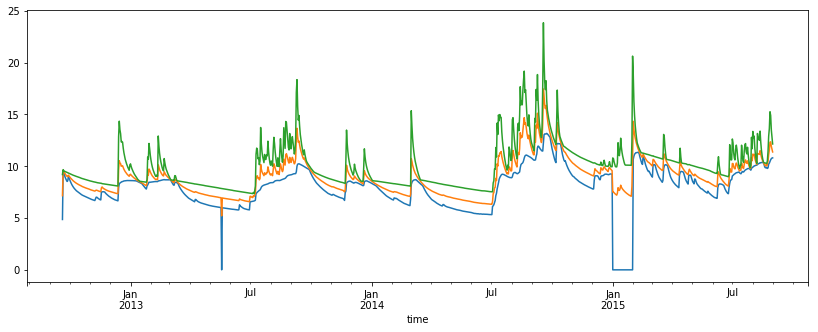

In [5]:
plt.rcParams['figure.figsize'] = [14, 5]

data["AirMOSS_L4_rootzone_mean"].plot()
data["AirMOSS_L4_rootzone_min"].plot()
data["AirMOSS_L4_rootzone_max"].plot()

---------------------------------------------
## Read USFS data from GeoJSON

The original dataset was a shapefile, but we reprojected and saved as GeoJSON using *ogr2ogr* from the GDAL/OGR binaries package available at OSGeo.

Let's open the GeoJSON and reorganize it as a pandas data frame. Read to a dictionary with `json.load` and print the first feature:

In [6]:
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)

features = shapes["features"]

feat = features[0]
feat["properties"]["id"] = 0
feat["properties"]["style"] = {"weight": 1, "fillOpacity": 0.5}

prop = feat["properties"]
prop

{'OBJECTID': 61,
 'RANGERDIST': '99030501010343',
 'REGION': '03',
 'FORESTNUMB': '05',
 'DISTRICTNU': '01',
 'DISTRICTOR': '030501',
 'FORESTNAME': 'Coronado National Forest',
 'DISTRICTNA': 'Douglas Ranger District',
 'GIS_ACRES': 434025.2,
 'SHAPE_Leng': 3.96360236158,
 'SHAPE_Area': 0.16722952205,
 'Rowid_': 59,
 'FID_1': 60,
 'COUNT': 8159,
 'AREA': 509937500.0,
 'MIN': -79,
 'MAX': 34,
 'RANGE': 113,
 'MEAN': -42.6505699228,
 'STD': 15.107567792,
 'SUM': -347986.0,
 'VARIETY': 96,
 'MAJORITY': -51,
 'MINORITY': -79,
 'MEDIAN': -44,
 'Count_1': 8270.0,
 'Count_2': 8269.0,
 'Count_3': 8270.0,
 'Count_4': 8271.0,
 'Count_5': 8269.0,
 'Count_6': 8257.0,
 'Count_7': 8266.0,
 'Count_8': 8273.0,
 'Count_9': 8272.0,
 'Count_10': 8274.0,
 'Count_11': 8253.0,
 'Count_12': 8256.0,
 'Count_13': 8263.0,
 'Count_14': 8268.0,
 'Count_15': 8262.0,
 'Count_16': 8234.0,
 'Count_17': 8263.0,
 'Count_18': 8268.0,
 'Count_19': 8245.0,
 'Count_20': 8224.0,
 'Count_21': 8272.0,
 'Count_22': 8271.0,
 'C

A feature's properties (AKA attributes) are stored in the "properties" element of the GeoJSON object:

In [7]:
geom = feat["geometry"]         # each feature has a geom
geom

{'type': 'MultiPolygon',
 'coordinates': [[[[-109.2462605499999, 32.05433095000002],
    [-109.24626015999993, 32.05070238000009],
    [-109.24625976999991, 32.04707352000008],
    [-109.2462594, 32.04344467000003],
    [-109.2462586499999, 32.03982309000004],
    [-109.24625792999993, 32.03620154000007],
    [-109.24625717999992, 32.032579690000105],
    [-109.24625642999995, 32.02895783000008],
    [-109.24625542999993, 32.02532931000008],
    [-109.24625441999994, 32.02170079000003],
    [-109.24625341999993, 32.018071990000045],
    [-109.24625241999995, 32.014443200000116],
    [-109.24625163999995, 32.010815260000065],
    [-109.24625083999995, 32.00718729000005],
    [-109.24625005999995, 32.003559080000066],
    [-109.2462492499999, 31.999930830000025],
    [-109.24624877999995, 31.996307030000132],
    [-109.24624830999991, 31.992683230000054],
    [-109.24199216999992, 31.99268452000005],
    [-109.23773602999992, 31.992685700000088],
    [-109.23773580999992, 31.989061420000

Data:

In [8]:
stats = pd.DataFrame({
    "mean": [v for k,v in prop.items() if "MEAN" in k],
    "std": [v for k,v in prop.items() if "STD" in k]})

stats.head(5)

,mean,std
0,-42.650570,15.107568
1,886.231560,569.668620
2,1182.049220,833.106219
3,1269.578235,813.900927
4,1307.410349,909.134138


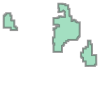

In [9]:
sgeom = shape(geom)     # Shapely.geometry.shape
bnds = sgeom.bounds
cent = sgeom.centroid

sgeom

Leaflet poly:

In [10]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
polys = mwg.LayerGroup()
points = mwg.LayerGroup()
m1 = mwg.Map(layers=(bmap,polys,points), center=(cent.y, cent.x), zoom=9)

poly = mwg.GeoJSON(data=feat)
m1.layers[1].add_layer(poly)

m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# EASE Grid

Spatial queries to the Soil Moisture Visualizer return data corresponding to 9- by 9-km cells within the EASE grid system. Read about the EASE grid at the NSIDC's web page: https://nsidc.org/data/ease

The next two cells show how to select arrays of EASE grid sample points that fall within an input polygon so that they can be used to submit a series of data requests to the SMV. We will combine everything into one more function (**get_ease**) to use later in our batch processing routine.
      
**Two binary files contain the arrays corresponding to global EASE grid centroid latitudes and longitudes, respectively. Open the two files and read into `numpy` arrays:**

In [11]:
lats = np.fromfile("docs/EASE2_M09km.lats.3856x1624x1.double", dtype=np.float64).flatten() 
lons = np.fromfile("docs/EASE2_M09km.lons.3856x1624x1.double", dtype=np.float64).flatten()
crds = np.dstack((lats,lons))[0]
crds

array([[  84.6564188 , -179.9533195 ],
       [  84.6564188 , -179.85995851],
       [  84.6564188 , -179.76659751],
       ...,
       [ -84.6564188 ,  179.76659751],
       [ -84.6564188 ,  179.85995851],
       [ -84.6564188 ,  179.9533195 ]])

Select a 2-dimensional array of EASE grid centroids using some arbitrary latitude, longitude bounds:

In [12]:
bnds = sgeom.bounds 
bnds

(-110.04372394999993,
 31.382951900000045,
 -108.92062104999994,
 32.13746836000006)

Get the points inside the polygon:

In [13]:
ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]
ease

array([[  32.08029092, -110.02593361],
       [  32.08029092, -109.93257261],
       [  32.08029092, -109.83921162],
       [  32.08029092, -109.74585062],
       [  32.08029092, -109.65248963],
       [  32.08029092, -109.55912863],
       [  32.08029092, -109.46576763],
       [  32.08029092, -109.37240664],
       [  32.08029092, -109.27904564],
       [  32.08029092, -109.18568465],
       [  32.08029092, -109.09232365],
       [  32.08029092, -108.99896266],
       [  31.99730645, -110.02593361],
       [  31.99730645, -109.93257261],
       [  31.99730645, -109.83921162],
       [  31.99730645, -109.74585062],
       [  31.99730645, -109.65248963],
       [  31.99730645, -109.55912863],
       [  31.99730645, -109.46576763],
       [  31.99730645, -109.37240664],
       [  31.99730645, -109.27904564],
       [  31.99730645, -109.18568465],
       [  31.99730645, -109.09232365],
       [  31.99730645, -108.99896266],
       [  31.91439556, -110.02593361],
       [  31.91439556, -1

In [14]:
mpt = lambda x,y: mwg.CircleMarker(      # map point
    location=(y,x),                       # lat,lon tuple
    radius=7,                             # in pixels
    stroke=False,
    fill_opacity=0.6,
    fill_color="black")


for p in ease:
    pt = mpt(p[1], p[0])
    points.add_layer(pt)
    
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [15]:
points.clear_layers()
point = lambda p: shape({"coordinates": p, "type": "Point"})

for p in ease:
    spt = point([p[1], p[0]])
    if sgeom.contains(spt):
        pt = mpt(p[1], p[0])
        points.add_layer(pt)
        
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Download a SMV dataset with `requests`
Each request to SMV takes a latitude `&lt` and longitude `&ln`. This request is for (30,-100):       
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

In [16]:
lt, ln = ease[0]
url = f"https://daac.ornl.gov/cgi-bin/viz/download.pl?lt={lt}&ln={ln}&d=smap"
r = requests.get(url, cookies=dict(ORNL_DAAC_USER_NUM="10"))
f = StringIO(r.text)

print("\n".join(f.readlines()[0:10]))

Filename: daily-smap-ORNL-DAAC-XXXXXX

Data_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.

Location: 32.0802909170736, -110.02593360995849

Citation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366





time,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl

2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;0.72;,;2.92;

2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

The two functions **txt_to_pd** and **split_pd** do everything we've learned to this point: convert the request response to a text object, then a data frame; and parse the columns of strings into three new columns.

In [17]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                      # get file from string
    df = pd.read_csv(f, header=4, index_col="time")  # read to df
    df.index = pd.to_datetime(df.index)              # convert index to dates
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)           # split col by ;
    df = df.replace('', np.nan)                       # set '' to nan
    df = df.astype(float)                             # set all to float
    df.columns = [col.name+s for s in ["_mean","_min","_max"]]
    return(df)

We use these repeatedly to request an process the entire grid:

In [170]:
df = txt_to_pd(r.text)
df.dropna(axis=1, how="all")

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl
time,,,,,,,,,,,,,,,,,,,,,
2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;0.72;,;2.92;
2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-03,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-04,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-05,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-06,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-07,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-08,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;1.76;,;2.92;
2002-04-09,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


In [18]:
df = txt_to_pd(r.text)
dfs = {col: split_pd(df[col]) for col in df.columns}

dfs["SMAP_rootzone"].tail(5)

,SMAP_rootzone_mean,SMAP_rootzone_min,SMAP_rootzone_max
time,,,
2019-02-21,21.01,21.07,21.09
2019-02-22,20.99,21.63,22.30
2019-02-23,22.06,22.16,22.27
2019-02-24,21.82,21.94,22.01
2019-02-25,21.61,21.74,21.78


## Reformat SMV data as a netCDF-like `xarray.Dataset`
The function below converts SMV outputs to an `xarray.Dataset`. The structure provided by `xarray` is based on pandas, but is better suited (in my opinion) for organizing data that has a spatial component. 

In [19]:
latatts = dict(
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

lonatts = dict(
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

s = xr.DataArray(data=[1], dims=["sample"])
y = xr.DataArray(data=[lt], coords=[s], dims=["sample"], attrs=latatts)
x = xr.DataArray(data=[ln], coords=[s], dims=["sample"], attrs=lonatts)

x

<xarray.DataArray (sample: 1)>
array([-110.025934])
Coordinates:
  * sample   (sample) int32 1
Attributes:
    standard_name:  latitude
    long_name:      sample latitude
    units:          degrees_north

Now add one more step to the response -> pandas -> split pandas workflow by making an xarray dataset. Print the SMAP_rootzone dataset:

In [91]:
def pd_to_xr(dataset, df, coords):
    """Makes an xr.Dataset from a pandas column (series) and coords."""
    
    a = smvds.loc[dataset].to_dict()
    x = xr.Dataset(df, attrs=a)
    for d in x:
        stat = d.split("_")[-1]
        hasdata = int(np.isnan(np.nanmean(x[d].data)))
        x[d].attrs = a
        x[d].attrs["nodata"] = hasdata
        x[d].attrs["stat"] = stat
    x["lon"], x["lat"] = coords[1:]
    return(x)

dfs = {col: split_pd(df[col]) for col in df.columns}
ds = {c: pd_to_xr(c,d,[s,x,y]) for c,d in dfs.items()}

ds["SMAP_rootzone"]

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


<xarray.Dataset>
Dimensions:             (sample: 1, time: 6175)
Coordinates:
  * time                (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * sample              (sample) int32 1
Data variables:
    SMAP_rootzone_mean  (time) float64 nan nan nan nan ... 22.06 21.82 21.61
    SMAP_rootzone_min   (time) float64 nan nan nan nan ... 22.16 21.94 21.74
    SMAP_rootzone_max   (time) float64 nan nan nan nan ... 22.27 22.01 21.78
    lon                 (sample) float64 -110.0
    lat                 (sample) float64 32.08
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-100cm 
    soil_zone:      rootzone
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present

<IPython.core.display.Javascript object>


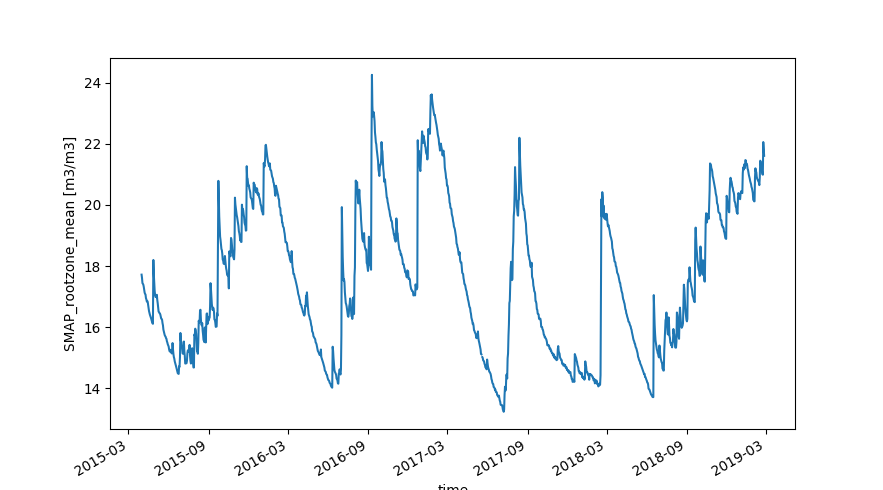

In [93]:
ds["SMAP_rootzone"]["SMAP_rootzone_mean"].plot()

Merge all datasets to one:

In [95]:
bigds = xr.merge(ds.values())
bigds

<xarray.Dataset>
Dimensions:                          (sample: 1, time: 6175)
Coordinates:
  * time                             (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * sample                           (sample) int32 1
Data variables:
    SoilSCAPE_surface_mean           (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_surface_min            (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_surface_max            (time) float64 nan nan nan ... nan nan nan
    lon                              (sample) float64 -110.0
    lat                              (sample) float64 32.08
    SoilSCAPE_rootzone_mean          (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone_min           (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone_max           (time) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface_mean        (time) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface_min         (time) float64 nan nan nan ... nan n

In [119]:
bigds["SMAP_surface_mean"]

<xarray.DataArray 'SMAP_surface_mean' (time: 6175)>
array([  nan,   nan,   nan, ..., 24.77, 22.31, 20.22])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-02-25
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-5cm 
    soil_zone:      surface
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    nodata:         0
    stat:           mean

In [169]:
bigds.dropna("sample") #how='all')

<xarray.Dataset>
Dimensions:                          (sample: 1, time: 6175)
Coordinates:
  * time                             (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * sample                           (sample) int32 1
Data variables:
    SoilSCAPE_surface_mean           (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_surface_min            (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_surface_max            (time) float64 nan nan nan ... nan nan nan
    lon                              (sample) float64 -110.0
    lat                              (sample) float64 32.08
    SoilSCAPE_rootzone_mean          (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone_min           (time) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone_max           (time) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface_mean        (time) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface_min         (time) float64 nan nan nan ... nan n

In [129]:
plottable = [d for d in bigds if bigds[d].dims==("time",)]        # datasets with time dim
plottable = [d for d in plottable if bigds[d].attrs["nodata"]==0] # datasets with data
plottable = bigds[plottable]
plottable

<xarray.Dataset>
Dimensions:                  (time: 6175)
Coordinates:
  * time                     (time) datetime64[ns] 2002-04-01 ... 2019-02-25
Data variables:
    SMAP_surface_mean        (time) float64 nan nan nan ... 24.77 22.31 20.22
    SMAP_surface_min         (time) float64 nan nan nan ... 25.96 23.84 21.82
    SMAP_surface_max         (time) float64 nan nan nan ... 27.06 24.32 22.35
    SMAP_rootzone_mean       (time) float64 nan nan nan ... 22.06 21.82 21.61
    SMAP_rootzone_min        (time) float64 nan nan nan ... 22.16 21.94 21.74
    SMAP_rootzone_max        (time) float64 nan nan nan ... 22.27 22.01 21.78
    NEE_mean_mean            (time) float64 nan nan nan ... -0.03 0.013 -0.048
    NEE_mean_min             (time) float64 nan nan nan nan ... 0.004 0.05 0.033
    NEE_mean_max             (time) float64 nan nan nan ... 0.037 0.087 0.114
    GPP_mean_mean            (time) float64 nan nan nan ... 0.427 0.412 0.694
    GPP_mean_min             (time) float64 nan nan

Now we can filter the big dataset by any of the attributes assigned to the little datasets:

In [140]:
statfilter = lambda s: s in ["mean","min"]
plottable.filter_by_attrs(soil_zone="rootzone", stat=statfilter)

<xarray.Dataset>
Dimensions:             (time: 6175)
Coordinates:
  * time                (time) datetime64[ns] 2002-04-01 ... 2019-02-25
Data variables:
    SMAP_rootzone_mean  (time) float64 nan nan nan nan ... 22.06 21.82 21.61
    SMAP_rootzone_min   (time) float64 nan nan nan nan ... 22.16 21.94 21.74

In [163]:
dates = plottable.time.data

timefilter = lambda t: dict(time=(t[0]<dates)& (dates < t[-1]))

t = [dates[1000], dates[2000]]

plottable.sel(timefilter(t))

<xarray.Dataset>
Dimensions:                  (time: 999)
Coordinates:
  * time                     (time) datetime64[ns] 2004-12-27 ... 2007-09-21
Data variables:
    SMAP_surface_mean        (time) float64 nan nan nan nan ... nan nan nan nan
    SMAP_surface_min         (time) float64 nan nan nan nan ... nan nan nan nan
    SMAP_surface_max         (time) float64 nan nan nan nan ... nan nan nan nan
    SMAP_rootzone_mean       (time) float64 nan nan nan nan ... nan nan nan nan
    SMAP_rootzone_min        (time) float64 nan nan nan nan ... nan nan nan nan
    SMAP_rootzone_max        (time) float64 nan nan nan nan ... nan nan nan nan
    NEE_mean_mean            (time) float64 nan nan nan nan ... nan nan nan nan
    NEE_mean_min             (time) float64 nan nan nan nan ... nan nan nan nan
    NEE_mean_max             (time) float64 nan nan nan nan ... nan nan nan nan
    GPP_mean_mean            (time) float64 nan nan nan nan ... nan nan nan nan
    GPP_mean_min             (time) 

We use this logic as the basis for the plotting UI:

<IPython.core.display.Javascript object>


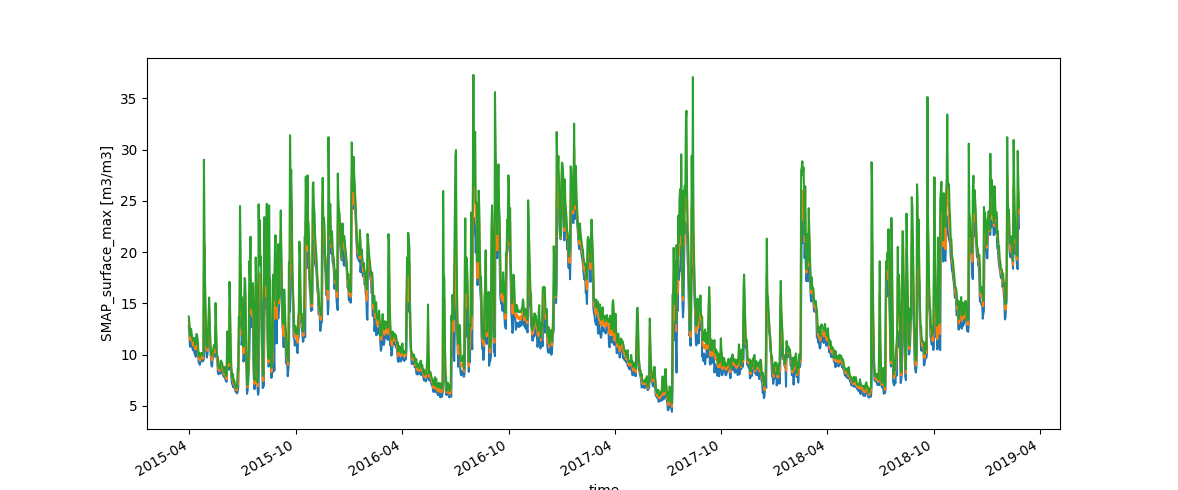

interactive(children=(SelectionRangeSlider(description='time', index=(0, 6174), layout=Layout(width='50%'), op…

In [166]:
%matplotlib notebook
from IPython.display import display
plt.rcParams['figure.figsize'] = [12, 5]
plt.ion()

dates = plottable.time.data
timefilter = lambda t: dict(time=(t[0]<dates)&(dates<t[-1]))

time_slider = wg.SelectionRangeSlider(
    options=dates,
    index=(0, len(dates)-1),
    disabled=False,
    layout=wg.Layout(width="50%"))

widgets = dict(
    time=time_slider,
    zone=[z for z in smvds.soil_zone.unique() if z is not np.nan],
    Minimum=True,
    Maximum=True,
    Mean=True)

# -------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def filt(time, zone, stats):
    """ """
    stats = [s for s,b in stats.items() if b]
    data = plottable.sel(timefilter(time))
    data = data.filter_by_attrs(
        soil_zone=zone, 
        stat=lambda s: s in stats)
    

def update(time, zone, Minimum, Maximum, Mean):
    """ """
    ax.clear()
    
    data = filt(
        time=time,
        zone=zone,
        stats={"min": Minimum, "max": Maximum, "mean": Mean})
    
    for d in data:
        data[d].plot(ax=ax)

    fig.canvas.draw()

p = wg.interactive(update, **widgets);
display(p)

<IPython.core.display.Javascript object>


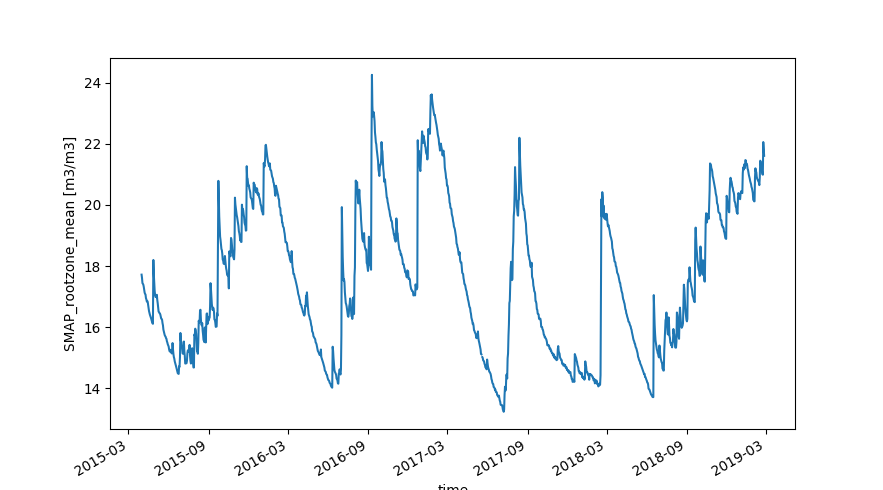

interactive(children=(SelectionRangeSlider(description='x', index=(0, 6174), layout=Layout(width='auto'), opti…

In [79]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 5]

smap_rootzone_mean = bigds["SMAP_rootzone_mean"]
dates = bigds.time.data

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = smap_rootzone_mean.plot(ax=ax)

def update(x):
    data = smap_rootzone_mean.loc[x[0]:x[1]]
    line.set_xdata(data.time.data)
    line.set_ydata(data.data)
    fig.canvas.draw()

wg.interact(update, x=wg.SelectionRangeSlider(
    options=dates,
    index=(0, len(dates)-1),
    disabled=False,
    layout=wg.Layout(width="auto")));

In [78]:
    line.set_xdata(data2.time.data)
    line.set_ydata(data2.data)
    fig.canvas.draw()
#from IPython.html import widgets
#from IPython.display import display,clear_output


#plt.ioff()
#ax=plt.gca()

#out=widgets.Output()
#slider = wg.SelectionRangeSlider(
#    options=dates,
#    index=(0, len(dates)-1),
#    disabled=False,
#    layout=wg.Layout(width="auto"))
#vbox=wg.VBox(children=(out,slider))
#display(vbox)

#def update(change):
    #ax.clear()
    #ix = change.new
    #with out:
    #    clear_output(wait=True)
    #    display(ax.figure)
#slider.observe(update, names="value")
    

In [ ]:

def exnan(variable):
    return(np.isnan(np.nanmean(variable)))

def filt(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)  # if attributes, filter with filter_by_attrs()
    return(data)

def flat(variable):
    if len(variable.dims)>1:
        return(variable.mean(dim="sample"))
    else:
        return(variable)


In [ ]:
x = np.linspace(0, 2 * np.pi)
fig = plt.figure()


def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw()

interact(update);

In [ ]:

def update(self, time=()):

    dim = self.dimsbool if dim is None else dim

    data = filt(self.xr, dim=dim, var=var, att=att)
    for v in data:
        variable = data[v]
        print(variable)
        #variable = flat()
        if not exnan(variable.data):
            variable.plot()

### Container for point samples
`Sample(<id>,<lat>,<lon>)`
* id: an integer id unique to the sample within it's input polygon
* lat, lon: latitude, longitude numerics

In [ ]:
class Sample(object):

    def __init__(self, *args):
        """Inits with id,lat,lon; makes request string, map point."""
        
        self.i, self.lat, self.lon = args                        # id, lat, lon
        self.rurl = url + f"lt={self.lat}&ln={self.lon}&d=smap"  # request url
        self.pt = mpt(self.lat, self.lon)
        
    def update_pt(self, **kwargs):
        """Called by submit. Takes dict of point properties, updates self.pt."""
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)        
        
    def toggle_pt(self, event, type, coordinates):
        """ """
        if self.on:
            self.on = False
            self.update_pt(opacity=0.1)
        else:
            self.on = True
            self.update_pt(opacity=0.6)  

    def submit(self):
        """Called by parent. Downloads url. Gets dict of xr.Datasets, 1/smv dataset."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df
        self.xr = get_xr(self.df, self.i, self.lat, self.lon)   # get xarray 
        self.pt.on_click(self.toggle_pt) 
        self.on = True                      # has on/off status depending on input

In [ ]:
points.clear_layers()
point = lambda p: shape({"coordinates": p, "type": "Point"})

for p in ease:
    
    spt = point([p[1], p[0]])
    
    if sgeom.contains(spt):
        
        pt = mpt(p[1], p[0])
        points.add_layer(pt)
        
m1

samples = pd.DataFrame(data=dict(
    mpt = list(points.layers),
    lon = [p.location[1] for p in list(points.layers)],
    lat = [p.location[0] for p in list(points.layers)]))

def update_pt(pt, **kwargs):
    """Called by submit. Takes dict of point properties, updates self.pt."""
    for arg, val in kwargs.items():
        setattr(pt, arg, val) 
            
def toggle_pt(event, type, coordinates):
    """ """
    lt,ln = coordinates
    row = samples.loc[(samples["lat"]==lt)&(samples["lon"]==ln)]
    update_pt(row["mpt"], opacity=0.1)
    #update_pt(opacity=0.6)
    
for p in points.layers:
    p.on_click(toggle_pt)
    
m1

In [ ]:
#m1.layers[1].popup = wg.HTML("text")

In [ ]:





selection = crds[(25<lats)&(lats<30)&(-90<lons)&(lons<-85)]
selection

This function uses the logic above to select an array of coordinates within bounding extent of the polygon:

In [ ]:
point = lambda p: shape({"coordinates": p, "type": "Point"})

def get_ease(geom):
    """ """
    bnds = geom.bounds 
    ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]
    inpoly = [p for p in ease if geom.contains(point([p[1], p[0]]))]
    return(inpoly)

Re-organize the properties a bit:

In [ ]:

site = {k:v for k,v in prop.items() if statcheck(k)}

print(json.dumps(site, indent=2))

In [ ]:

group = mwg.LayerGroup()

mapw = mwg.Map(
    layers=(bmap, group),            # basemap; poly container
    center=(33, -109),               # map center
    zoom=7,                          # zoom level
    scroll_wheel_zoom=True)          # scrollable

Get the stats columns as a table:

Read an example file from txt:

The columns have three values separated by semicolons: mean, min, max. Split them with str.split:

In [ ]:
def getmap(layers, cent):
    b = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
    l = l if type(layers) is list else [layers]
    m = mwg.Map(layers=([b]+l), center=(cent.y, cent.x), zoom=9)
    return(m)

m1 = getmap(poly, cent)


In [ ]:

data.plot()

The `xarray.Dataset` is easily saved to netCDF:

In [ ]:
ds["SMAP_rootzone"].to_netcdf("SMAP_rootzone-ex.nc")  # save to a netcdf
r, df, c, ds = None, None, None, None     # remove old data

The app that we build at the end of the tutorial will be driven by data stored in one big `xarray.Dataset`, arranged with dozens of requests arranged in a gridded system described below. The function below allows us to merge a list of datasets along the **sample** dimension:

In [ ]:
def get_xr(df, i, lat, lon): 
    """ """
    d, nm = ["sample"], ["sample"+("%02d"%i)]
    s = xr.DataArray(data=[i], dims=["sample"])
    sn = xr.DataArray(data=nm, coords=[s], dims=d, attrs=snatts)
    y = xr.DataArray(data=[30], coords=[s], dims=d, attrs=latatts)
    x = xr.DataArray(data=[-100], coords=[s], dims=d, attrs=lonatts)
    sc = {c: split_pd(df[c]) for c in df}
    ds = {c: pd_to_xr(c,d,[s,sn,x,y]) for c,d in sc.items()}
    return(ds)


def xrdataset(samples, datasets):
    """ """
    bydataset = []                                  # xr dataset for each dataset
    for d in datasets:                              # loop over dataset names
        xrds = [s[d] for s in samples.values()]     # get dataset for all samples
        bydataset.append(xr.concat(xrds, "sample")) # concat all along sample dim
    return(xr.merge(bydataset))                     # merge all concat'd datasets

---------------------------------
## Building a Jupyter app around the SMV

What we need:
* container for point samples
* class to manage dynamic info
* pandas data frame to hold all the data we just took from the USFS site features
* widgets

### Container for point samples
`Sample(<id>,<lat>,<lon>)`
* id: an integer id unique to the sample within it's input polygon
* lat, lon: latitude, longitude numerics

In [ ]:
class Sample(object):

    def __init__(self, *args):
        """Inits with id,lat,lon; makes request string, map point."""
        self.i, self.lat, self.lon = args                        # id, lat, lon
        self.rurl = url + f"lt={self.lat}&ln={self.lon}&d=smap"  # request url
        
        self.pt = mwg.CircleMarker(                              # map point
            location=(self.lat, self.lon),  # lat,lon tuple
            radius=7,                       # in pixels
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")
        
    def update_pt(self, **kwargs):
        """Called by submit. Takes dict of point properties, updates self.pt."""
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)        
        
    def toggle_pt(self, event, type, coordinates):
        """ """
        if self.on:
            self.on = False
            self.update_pt(opacity=0.1)
        else:
            self.on = True
            self.update_pt(opacity=0.6)  

    def submit(self):
        """Called by parent. Downloads url. Gets dict of xr.Datasets, 1/smv dataset."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df
        self.xr = get_xr(self.df, self.i, self.lat, self.lon)   # get xarray 
        
        self.pt.on_click(self.toggle_pt) 
        self.on = True                      # has on/off status depending on input

        
# example use:
easept = selection[0]
sample = Sample(0, easept[0], easept[1])    # Sample instance
sample.submit()                             # send request to SMV and process download

sample.xr['SMAP_rootzone'] # print SMAP_rootzone dataset

### Data frame for USFS sites 

One more thing before we make the data frame. Steps to get nice colors for the map polygons:
1. use [`numpy.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to make an array of evenly-spaced values between 0-1 
2. map values to **Set3** in [`matplotlib.cm`](https://matplotlib.org/api/cm_api.html) | [colormap reference](https://matplotlib.org/gallery/color/colormap_reference.html)
3. convert to hexadecimal with [`matplotlib.colors.to_hex`](https://matplotlib.org/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex)

In [ ]:
cspace = np.linspace(0.0, 1.0, len(features)) # 1
rgb = cm.Set3(cspace)                         # 2
cols = [colors.to_hex(c[0:3]) for c in rgb]   # 3

cols

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.to_html.html

Loop over each feature, make map layers and collect info into a data frame:

In [ ]:
pstyle = lambda c,w,f: {"color":c, "fillColor":c, "weight":w, "fillOpacity":f}
hstyle = {"color": "white", "fillOpacity": 0.8}

layers = []

for i, feat in enumerate(features):
    geom = feat["geometry"]
    shp = shape(geom)       
    cent = shp.centroid     
    ease = get_ease(shp)
    col = cols[i]
    
    prop = feat["properties"]
    site = {k:v for k,v in prop.items() if statcheck(k)}
    stats = pd.DataFrame({
        "mean": [v for k,v in prop.items() if "MEAN" in k], 
        "std": [v for k,v in prop.items() if "STD" in k]})
    
    samples = [Sample(j,p[1],p[0]) for j,p in enumerate(ease)]
    pts = [s.pt for s in samples]
    grp = mwg.LayerGroup(layers=tuple(pts))
    
    feat["properties"]["id"] = i
    feat["properties"]["style"] = pstyle(col,1,0.5)
    poly = mwg.GeoJSON(data=feat,hover_style=hstyle)
    
    layers.append((feat, site, stats, cent, ease, col, poly, samples, pts, grp))

df = pd.DataFrame(layers)
df.columns = [
    "feat", 
    "site", 
    "stats", 
    "cent", 
    "ease", 
    "col", 
    "poly", 
    "samples", 
    "pts", 
    "grp"]

df.head(5)

* `ipyleaflet` map widget
* submit button to begin sending series of requests to the SMV
* progress bar to monitor progress of the requests

In [ ]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
group = mwg.LayerGroup()

mapw = mwg.Map(
    layers=(bmap, group),            # basemap; poly container
    center=(33, -109),               # map center
    zoom=7,                          # zoom level
    scroll_wheel_zoom=True)          # scrollable

submit = wg.Button(
    description='Submit', 
    disabled=True, 
    button_style='success')

progress = wg.IntProgress(
    description="Progress: ", 
    layout=wg.Layout(width="95%"))

ui = wg.VBox([mapw,wg.HBox([submit,progress])])

(ui, group, (mapw, submit, progress))

### Class to manage dynamic info
**button_click_handler** reacts to user clicking the submit button by iterating over the sample EASE points resulting from the **layer_click_handler** above and sends the download requests to the SMV and converts text to xarray:

In [ ]:
datasets = [d for d in smvds.index.tolist() if "FLUXNET" not in d] # fluxnet broken??


class App(object):

    def __init__(self, df, ui):
        self.df = df
        self.ui, self.group, widgets = ui
        self.map, self.submit, self.progress = widgets
        for poly in self.df["poly"]:              # loop over rows
            poly.on_click(self.layer_update)      #   set callback
            self.group.add_layer(poly)              #   add to layer group 
        self.submit.on_click(self.submit_handler) # set submit bttn callback 
        self.points = None
        
    def layer_update(self, **kwargs): 
        """Routine for when a new USFS polygon is selected."""
        if list(kwargs.keys()) != ['event', 'properties']: # check event; skip bmap
             return(None)

        self.id = int(kwargs["properties"]["id"]) # set selected poly id
        self.site = self.df.iloc[self.id]         # get row for selected
        self.pts = self.site["pts"]
        self.samples = self.site["samples"]       # list of class Sample
        
        cent = self.site["cent"]
        self.map.center = (cent.y, cent.x)        # center map
        self.map.zoom = 9                         # zoom map
            
        self.submit.disabled = False              # enable submit bttn
        if self.points:
            self.map.remove_layer(self.points)    # clear ease grid pts
        
        self.points = self.site["grp"]            # add to map 
        self.map.add_layer(self.points)      

            
    def submit_handler(self, b):
        """Resets UI and sends requests to SMV when new submit."""
        self.pbar.min = 0                         # reset progress bar
        self.pbar.max = len(self.points.layers)   #
        self.pbar.value = 0                       #
        self.submit.disabled = True               # disable submit button
        
        for samp in self.samples:                 # loop over sample pts
            self.sub[1].value += 1                # update progress bar
            samp.update_pt(                       # update style
                stroke=True, color="white", opacity=0.6)
            samp.submit()                         # download the data
            #samp.pt.on_click(sample_update)      # do something to plots
            
        self.xr = xrdataset(self.data, datasets)  # merge all data as x        
    
    #def sample_update(self): ...
    #def plotter(self, dataset, clear=True): ...

# Put it all the steps together; display the app
The classes above provide all of the functionality of the app. The three steps below 

Open the input GeoJSON and get data frame structure we created before.

In [ ]:
app = App(df)
app.ui

# Display the UI

**Instructions:**
1. Run the following cell.          
2. Select a USFS polygon on the map; an array of EASE grid points will be displayed that represent the locations of the data available through the Soil Moisture Visualizer API.               
3. Click *Submit*; wait for the downloads to process.            
4. Explore the data interactively.            
    * Click a point to toggle the associated data on and off; this adds/removes the data for all visualizations.
    * Double click a point to disable all other points.

In [ ]:
appdata.ui

## plotter class

In [ ]:
%matplotlib notebook

def exnan(variable):
    return(np.isnan(np.nanmean(variable)))

def filt(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)  # if attributes, filter with filter_by_attrs()
    return(data)

def flat(variable):
    """ """
    if len(variable.dims)>1:
        return(variable.mean(dim="sample"))
    else:
        return(variable)

# ---------------------------------------------------------------------------------


class Plotting(object):
    
    def __init__(self, xr, chkbx, samples):
        self.xr = xr
        self.chk = chkbx
        self.samp = samples
        
        self.smv = [v for v in list(self.xr) if "source" in self.xr[v].attrs]
        
        self.chkbools = {} # add updater callback to all checkboxes; build bools table
        for group in self.chk:
            self.chkbools[group] = {}
            for dataset in self.chk[group]:
                dataset.observe(self.att_updater, names='value')
                desc = dataset.description
                self.chkbools[group][desc] = dataset.value
                
        self.sampbools = [] # add updater callback for pt clicks
        for i, sample in self.samp.items():
            self.sampbools.append((i, sample.lat, sample.lon, sample.on))
            sample.pt.on_click(self.samp_updater)
        self.sampbools = pd.DataFrame(self.sampbools, columns=["id","y", "x","on"])
        self.sampbools = self.sampbools.set_index("id")


    def samp_updater(self, event, type, coordinates):
        """ """
        id = self.sampbools.loc[
            (self.sampbools["y"]==coordinates[0]) & 
            (self.sampbools["x"]==coordinates[1])]
        if self.sampbools[id]["on"]:
            self.sampbools.at[id, "on"] = False
        else:
            self.sampbools.at[id, "on"] = True
            
        t = []
        for i, row in self.sampbools.iterrows():
            if row["on"]:
                t.append(i)
        self.dimsbool = dict(sample=t)
        self.plot()
        

    def att_updater(self, change):

        # update bools table     --->>> attributes
        attribute_filter=dict()
        desc = change.owner.description
        for g in self.chkbools:
            for d in self.chkbools[g]:
                if d==desc:
                    self.chkbools[g][d] = change.new
        #source = [a for a,v in self.chkbools["source"] if not v]
        #units = [a for a,v in self.chkbools["units"] if not v]
        #native_res = [a for a,v in self.chkbools["native_res"] if not v]
        #type = [a for a,v in self.chkbools["type"] if not v]
        #soil_zone = [a for a,v in self.chkbools["soil_zone"] if not v] <<<---

         
    def plot(self, dim=None, var=None, att=None):
        """ """
        
        dim = self.dimsbool if dim is None else dim
        
        data = filt(self.xr, dim=dim, var=var, att=att)
        for v in data:
            variable = data[v]
            print(variable)
            #variable = flat()
            if not exnan(variable.data):
                variable.plot()

In [ ]:
p = Plotting(appdata.xr, chkbx_grps, appdata.data)

----------------------------------------------------------
```
#
#
#
#
#
#
#
#
```

In [ ]:
p.plot(
    dim=dict(sample=1),                            # not required; omit to average
    #var=["SMAP_surface_mean", "SMAP_surface_max"], # not required; list of vars
    att=dict(source="SMAP")
)

In [ ]:
p.chkbools

In [ ]:
def basic_filter(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)
    return(data)

def basic_plot(data):
    smv = [v for v in list(data) if "source" in data[v].attrs] # get plottable vars
    for v in smv:
        nancheck = np.isnan(np.nanmean(data[v].data))
        if not nancheck:
            if len(data.dims)>1:
                data[v].mean(dim="sample").plot()
            else:
                data[v].plot()

In [ ]:
filtered = basic_filter(
    appdata.xr,                                    # the big xarray dataset
    dim=dict(sample=1),                            # not required; omit to average
    var=["SMAP_surface_mean", "SMAP_surface_max"], # not required; list of vars
    att=dict(source="SMAP"))                       # not required; filter by att:value pair

filtered

In [ ]:
%matplotlib notebook
basic_plot(filtered)

# checkbox groups testing:

In [ ]:
# ---------------------------------------------------------------------------------
# checkbox groups

smvds2 = smvds.drop(["FLUXNET_surface","FLUXNET_rootzone"])         # FLUXNET is broken???
grps = ["source", "units", "native_res","type", "soil_zone"]

def chkbx(d):
    c = wg.Checkbox(
        value=True, 
        indent=False, 
        description=str(d), 
        disabled=True, 
        layout=wg.Layout(
            width='auto', 
            overflow_y="hidden"))
    return(c)

lbl = lambda d: [wg.HTML("<b>"+d+"</b>")]
chkbx_grps = {d: list(map(chkbx, smvds2[d].unique())) for d in grps}
chkbx_ui = wg.HBox(
    children=[wg.VBox(lbl(n)+g) for n,g in chkbx_grps.items()], 
    layout=wg.Layout(border='1px solid lightgray', width="45%"))

# ---------------------------------------------------------------------------------



# ---------------------------------------------------------------------------------
smvds2 = smvds.drop(["FLUXNET_surface","FLUXNET_rootzone"])                     # FLUXNET is broken???
grps = ["source", "units", "native_res","type", "soil_zone"]

lyt = wg.Layout(width='auto', overflow_y="hidden")
chkbx = lambda a: wg.Checkbox(value=False, description=str(d), indent=False, disabled=True, layout=lyt)
lbl = lambda d: [wg.HTML("<b>"+d+"</b>")]

chkbx_grps = {d: list(map(chkbx, smvds2[d].unique())) for d in grps}
chkbx_ui = wg.HBox(
    children=[wg.VBox(lbl(n)+g) for n,g in chkbx_grps.items()], 
    layout=wg.Layout(border='1px solid lightgray', width="45%"))


def filt(self, data=None, dim=None, attr=None):      
    """
    Dims, attrs are both dictionaries. e.g.
      attrs: dict(soil_zone="surface", units="m3/m3")
      dims: dict(sample=0)
    """
    data = data if data else self.xr
    if dim:
        data = data.isel(**dim)                 # filter by dimensions dict
    if attr:
        data = data.filter_by_attrs(**attr)   # filter by attribute dict
    return(data)